In [1]:
import polars as pl
import numpy as np

In [2]:
train_df = pl.read_csv("data/data/train.csv")
test_df = pl.read_csv("data/data/test.csv")

In [3]:
# Get null count for each column in the test dataframe
null_counts = test_df.null_count()

# Display the results in a more readable format
print("Null counts in test_df:")
for column, count in zip(test_df.columns, null_counts.row(0)):
    print(f"{column}: {count}")


Null counts in test_df:
id: 0
Podcast_Name: 0
Episode_Title: 0
Episode_Length_minutes: 28736
Genre: 0
Host_Popularity_percentage: 0
Publication_Day: 0
Publication_Time: 0
Guest_Popularity_percentage: 48832
Number_of_Ads: 0
Episode_Sentiment: 0


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Drop nulls from the dataframe
clean_df = train_df.drop_nulls(["Episode_Length_minutes", "Listening_Time_minutes"])

# Create a new column for the constant term (intercept)
clean_df = clean_df.with_columns(pl.lit(1).alias("const"))

# Convert to pandas for statsmodels
pd_df = clean_df.to_pandas()

# Run OLS regression
X = pd_df[["const", "Episode_Length_minutes"]]
y = pd_df["Listening_Time_minutes"]
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Listening_Time_minutes   R-squared:                       0.840
Model:                                OLS   Adj. R-squared:                  0.840
Method:                     Least Squares   F-statistic:                 3.491e+06
Date:                    Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                            21:21:54   Log-Likelihood:            -2.5237e+06
No. Observations:                  662907   AIC:                         5.047e+06
Df Residuals:                      662905   BIC:                         5.047e+06
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [5]:
# Calculate predictions
predictions = model.predict(X)

# Calculate RMSE (Root Mean Squared Error)
mse = np.mean((y - predictions) ** 2)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Root Mean Squared Error (RMSE): 10.8930


In [6]:
##IMPUTE THEN RERUN
from sklearn.ensemble import RandomForestRegressor

train = train_df.filter(pl.col("Episode_Length_minutes").is_not_null()).to_pandas()
test  = train_df.filter(pl.col("Episode_Length_minutes").is_null()).to_pandas()

features = ["Host_Popularity_percentage", "Guest_Popularity_percentage", "Number_of_Ads"]
X_train = train[features]
y_train = train["Episode_Length_minutes"]
X_test  = test[features]

# fit & predict
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

test["Episode_Length_imp"] = preds
train["Episode_Length_imp"] = train["Episode_Length_minutes"]

# combine
import pandas as pd
combined = pd.concat([train, test], sort=False)
df = pl.from_pandas(combined)

In [7]:
# Print the count of null values for each column in the dataframe
print("Null values in each column:")
for column in df.columns:
    null_count = df.filter(pl.col(column).is_null()).height
    print(f"{column}: {null_count}")


Null values in each column:
id: 0
Podcast_Name: 0
Episode_Title: 0
Episode_Length_minutes: 87093
Genre: 0
Host_Popularity_percentage: 0
Publication_Day: 0
Publication_Time: 0
Guest_Popularity_percentage: 146030
Number_of_Ads: 1
Episode_Sentiment: 0
Listening_Time_minutes: 0
Episode_Length_imp: 0


In [8]:
print(df['Episode_Length_imp'])

shape: (750_000,)
Series: 'Episode_Length_imp' [f64]
[
	119.8
	73.9
	67.17
	110.51
	26.54
	…
	43.3394
	61.083731
	68.0408
	64.6382
	37.866
]


In [9]:
clean_df = df.drop_nulls(["Episode_Length_imp", "Listening_Time_minutes"])

# Create a new column for the constant term (intercept)
clean_df = clean_df.with_columns(pl.lit(1).alias("const"))

# Convert to pandas for statsmodels
pd_df = clean_df.to_pandas()

# Run OLS regression
X = pd_df[["const", "Episode_Length_imp"]]
y = pd_df["Listening_Time_minutes"]
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Listening_Time_minutes   R-squared:                       0.740
Model:                                OLS   Adj. R-squared:                  0.740
Method:                     Least Squares   F-statistic:                 2.131e+06
Date:                    Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                            21:22:30   Log-Likelihood:            -3.0353e+06
No. Observations:                  750000   AIC:                         6.071e+06
Df Residuals:                      749998   BIC:                         6.071e+06
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [10]:
# Calculate predictions
predictions = model.predict(X)

# Calculate RMSE (Root Mean Squared Error)
mse = np.mean((y - predictions) ** 2)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Root Mean Squared Error (RMSE): 13.8473


Alpha: 0.01, RMSE: 26.7938
Alpha: 0.1, RMSE: 26.7938
Alpha: 1.0, RMSE: 26.7938
Alpha: 10.0, RMSE: 26.7938
Alpha: 100.0, RMSE: 26.7938

Best Alpha: 100.0, Best RMSE: 26.7938
Final Ridge Regression RMSE: 26.7938


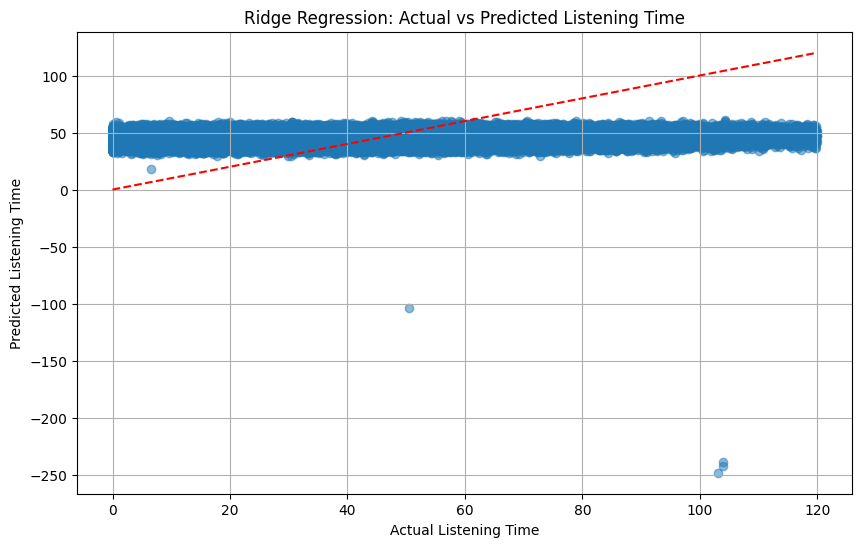

In [14]:
# Import necessary libraries for Ridge regression
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# First, let's create a copy of the dataframe for our ridge regression
ridge_df = train_df.clone()

# Drop the original Episode_Length_minutes column
if "Episode_Length_minutes" in ridge_df.columns:
    ridge_df = ridge_df.drop("Episode_Length_minutes")

# Convert categorical columns to numerical using one-hot encoding
categorical_columns = ["Podcast_Name", "Episode_Title", "Genre", "Publication_Day", 
                       "Publication_Time", "Episode_Sentiment"]

# Create dummy variables for each categorical column
for col in categorical_columns:
    if col in ridge_df.columns:
        # Get unique values
        unique_values = ridge_df[col].unique().to_list()
        
        # Create dummy variables
        for value in unique_values:
            ridge_df = ridge_df.with_columns(
                pl.when(pl.col(col) == value).then(1).otherwise(0).alias(f"{col}_{value}")
            )
        
        # Drop the original categorical column
        ridge_df = ridge_df.drop(col)

median_guest_pop = ridge_df.filter(pl.col("Guest_Popularity_percentage").is_not_null()).get_column("Guest_Popularity_percentage").median()
ridge_df = ridge_df.with_columns(
    pl.when(pl.col("Guest_Popularity_percentage").is_null())
    .then(median_guest_pop)
    .otherwise(pl.col("Guest_Popularity_percentage"))
    .alias("Guest_Popularity_percentage")
)

# Impute Number_of_Ads (just 1 missing value) using mode
mode_ads = ridge_df.filter(pl.col("Number_of_Ads").is_not_null()).get_column("Number_of_Ads").mode().to_list()[0]
ridge_df = ridge_df.with_columns(
    pl.when(pl.col("Number_of_Ads").is_null())
    .then(mode_ads)
    .otherwise(pl.col("Number_of_Ads"))
    .alias("Number_of_Ads")
)


# Drop nulls for the target variable
ridge_df = ridge_df.drop_nulls("Listening_Time_minutes")

# Convert to pandas for sklearn
pd_ridge_df = ridge_df.to_pandas()

# Separate features and target
y_ridge = pd_ridge_df["Listening_Time_minutes"]
X_ridge = pd_ridge_df.drop(columns=["Listening_Time_minutes", "id"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_ridge, y_ridge, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Ridge regression model
alpha_values = [0.01, 0.1, 1.0, 10.0, 100.0]
best_alpha = None
best_rmse = float('inf')

for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = ridge_model.predict(X_test_scaled)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Alpha: {alpha}, RMSE: {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"\nBest Alpha: {best_alpha}, Best RMSE: {best_rmse:.4f}")

# Train the final model with the best alpha
final_ridge_model = Ridge(alpha=best_alpha)
final_ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
final_predictions = final_ridge_model.predict(X_test_scaled)

# Calculate final RMSE
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final Ridge Regression RMSE: {final_rmse:.4f}")

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title('Ridge Regression: Actual vs Predicted Listening Time')
plt.grid(True)
plt.show()
